# M2 Agentic AI - Chart Generation

We’re excited to have you here in the **Agentic AI** course! In this **ungraded lab**, and those that follow in the rest of the course, you’ll have a chance to try out code examples that implement the concepts and design patterns you’ll see in the lecture videos.

Think of these labs as **sandbox**: a safe practice space where you can deepen your understanding of the course concepts, build confidence, and get ready for the graded exercises that come later. In each lab, try running the code cells to see some agentic workflows in action and better understand how they work. 

In a few places, you’ll be encouraged to try making modifications to the code - such as changing the prompts, testing with different LLMs, or adding additional queries to the workflow. Please try experimenting to see how your changes impact the behavior of the workflow.

Most importantly, ungraded labs are an opportunity to learn at your own pace while getting hands-on experience with the core ideas behind **Agentic AI**. And remember—you’re not learning alone! If you have any questions, feel free to ask in the
<a href="https://community.deeplearning.ai/c/course-q-a/agentic-ai/567" target="_blank">community</a>


## 1. Introduction
### 1.1. Lab overview

In this ungraded lab, you will implement the **reflection pattern** introduced in the lecture video within an agentic workflow that generates data visualizations. A multi-modal LLM will review the first draft chart, identify potential improvements—such as chart type, labels, or color choices—and then rewrite the chart generation code to produce a more effective visualization.

In the video, Andrew presented the following workflow for analyzing coffee sales. You will implement this in code here. The steps that the workflow will carry out are:

1. **Generate an initial version (V1):**
Use a Large Language Model (LLM) to create the first version of the plotting code.

2. **Execute code and create chart:** 
Run the generated code and display the resulting chart. ** (check everywhere)

3. **Reflect on the output:**
Evaluate both the code and the chart using an LLM to detect areas for improvement (e.g., clarity, accuracy, design).

4. **Generate and execute improved version (V2):**
Produce a refined version of the plotting code based on reflection insights and render the enhanced chart.

<img src='M2-UGL-2.png'>

### 🎯 1.2. Learning outcome

By the end of this lab, you will have implemented the reflection pattern in code and used it to improve a data visualization.

## 2. Setup: Initialize environment and client

In this step, you import the key libraries that will support the workflow:  

- **`re`**: Python’s regular expression module, which you’ll use to extract snippets of code or structured text from the LLM’s output.  
- **`json`**: Provides functions to read and write JSON, useful for handling structured responses returned by the LLM.  
- **`utils`**: A custom helper module provided for this lab. It includes utility functions to work with the dataset, generate charts, and display results in a clean, readable format.  


In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")
if openai_key:
    print(f"✅ OpenAI API Key loaded: {openai_key[:20]}...")
else:
    print("❌ OpenAI API Key not found")

✅ OpenAI API Key loaded: sk-proj--0EjYIN0-Gac...


In [2]:
# Standard library imports
import re
import json

# Local helper module
import utils

### 2.1. Loading the dataset

Let’s take a look at the coffee sales data to see what information is contained in the file.

In [3]:
# Use this utils.py function to load the data into a dataframe
df = utils.load_and_prepare_data('coffee_sales.csv')

# Grab a random sample to display
utils.print_html(df.sample(n=5), title="Random Sample of Coffee Sales Data")

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-12-28,10:00,card,ANON-0000-0000-0141,2.596,Cortado,4,12,2024
2024-09-05,08:56,card,ANON-0000-0000-0583,3.282,Latte,3,9,2024
2024-11-11,06:15,card,ANON-0000-0000-0696,3.576,Cappuccino,4,11,2024
2025-02-27,11:55,card,ANON-0000-0000-1170,2.596,Americano,1,2,2025
2025-02-05,16:08,card,ANON-0000-0000-1181,3.576,Cappuccino,1,2,2025


You’ll build an agentic workflow that generates data visualizations from this dataset, helping you answer questions about coffee sales from the vending machine.

## 3. Building the pipeline

### 3.1 Step 1 — Generate Code to Create a Chart (V1)

In this step, you’ll prompt an LLM to write Python code that generates a chart in response to a user query about the coffee dataset. The dataset includes fields such as `date`, `coffee_type`, `quantity`, and `revenue`, and you will pass this schema into the LLM so it knows what data is available.  

The question you’ll ask the model is the same one used in the lecture:  
**“Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.”**

The LLM’s output will be Python code using the **matplotlib** library. Instead of displaying the chart directly, the code will be written between `<execute_python>` tags so it can be extracted and run in later steps. You’ll learn more about these tags in Module 3.  


In [4]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

    response = utils.get_response(model, prompt)
    return response

Now, try out the function and analyze the response!

In [7]:
# Generate initial code
code_v1 = generate_chart_code(
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.", 
    model="gpt-4o-mini", 
    # model="gpt-5-codex", 
    out_path_v1="chart_v1.png"
)

utils.print_html(code_v1, title="LLM output with first draft code")

Great! You've generated some python code to create a chart! 

Notice that the code is wrapped between `<execute_python>` tags. These tags make it easy to automatically extract and run the code in the next step of the workflow.  

You don’t need to worry about the details yet — you’ll learn more about how these tags work in **Module 3**.  


### 3.2. Step 2 — Execute Code and Create Chart

In this step, you’ll use a regular expression to extract the Python code that the LLM generated in the previous step (the part written between `<execute_python>` tags). Once extracted, you’ll run this code to produce the **first draft chart**.  

Here's how it works:

1. **Extract the code:**  
   A regex pattern is used to grab the code that’s wrapped inside the `<execute_python>` tags.

2. **Execute the code:**
   The extracted code is run in a predefined global context where the DataFrame `df` is already available. This means your code can directly use df without needing to reload the dataset.

3. **Generate the chart::**
   If the code executes successfully, it will create a chart and save it as `chart_v1.png`.

4. **View the chart in the notebook:**
   The saved chart is then displayed inline using `utils.print_html`, making it easy for you to review the results.

By completing this step, you’ll have your first draft visualization (V1) ready — a big milestone in the reflection workflow!


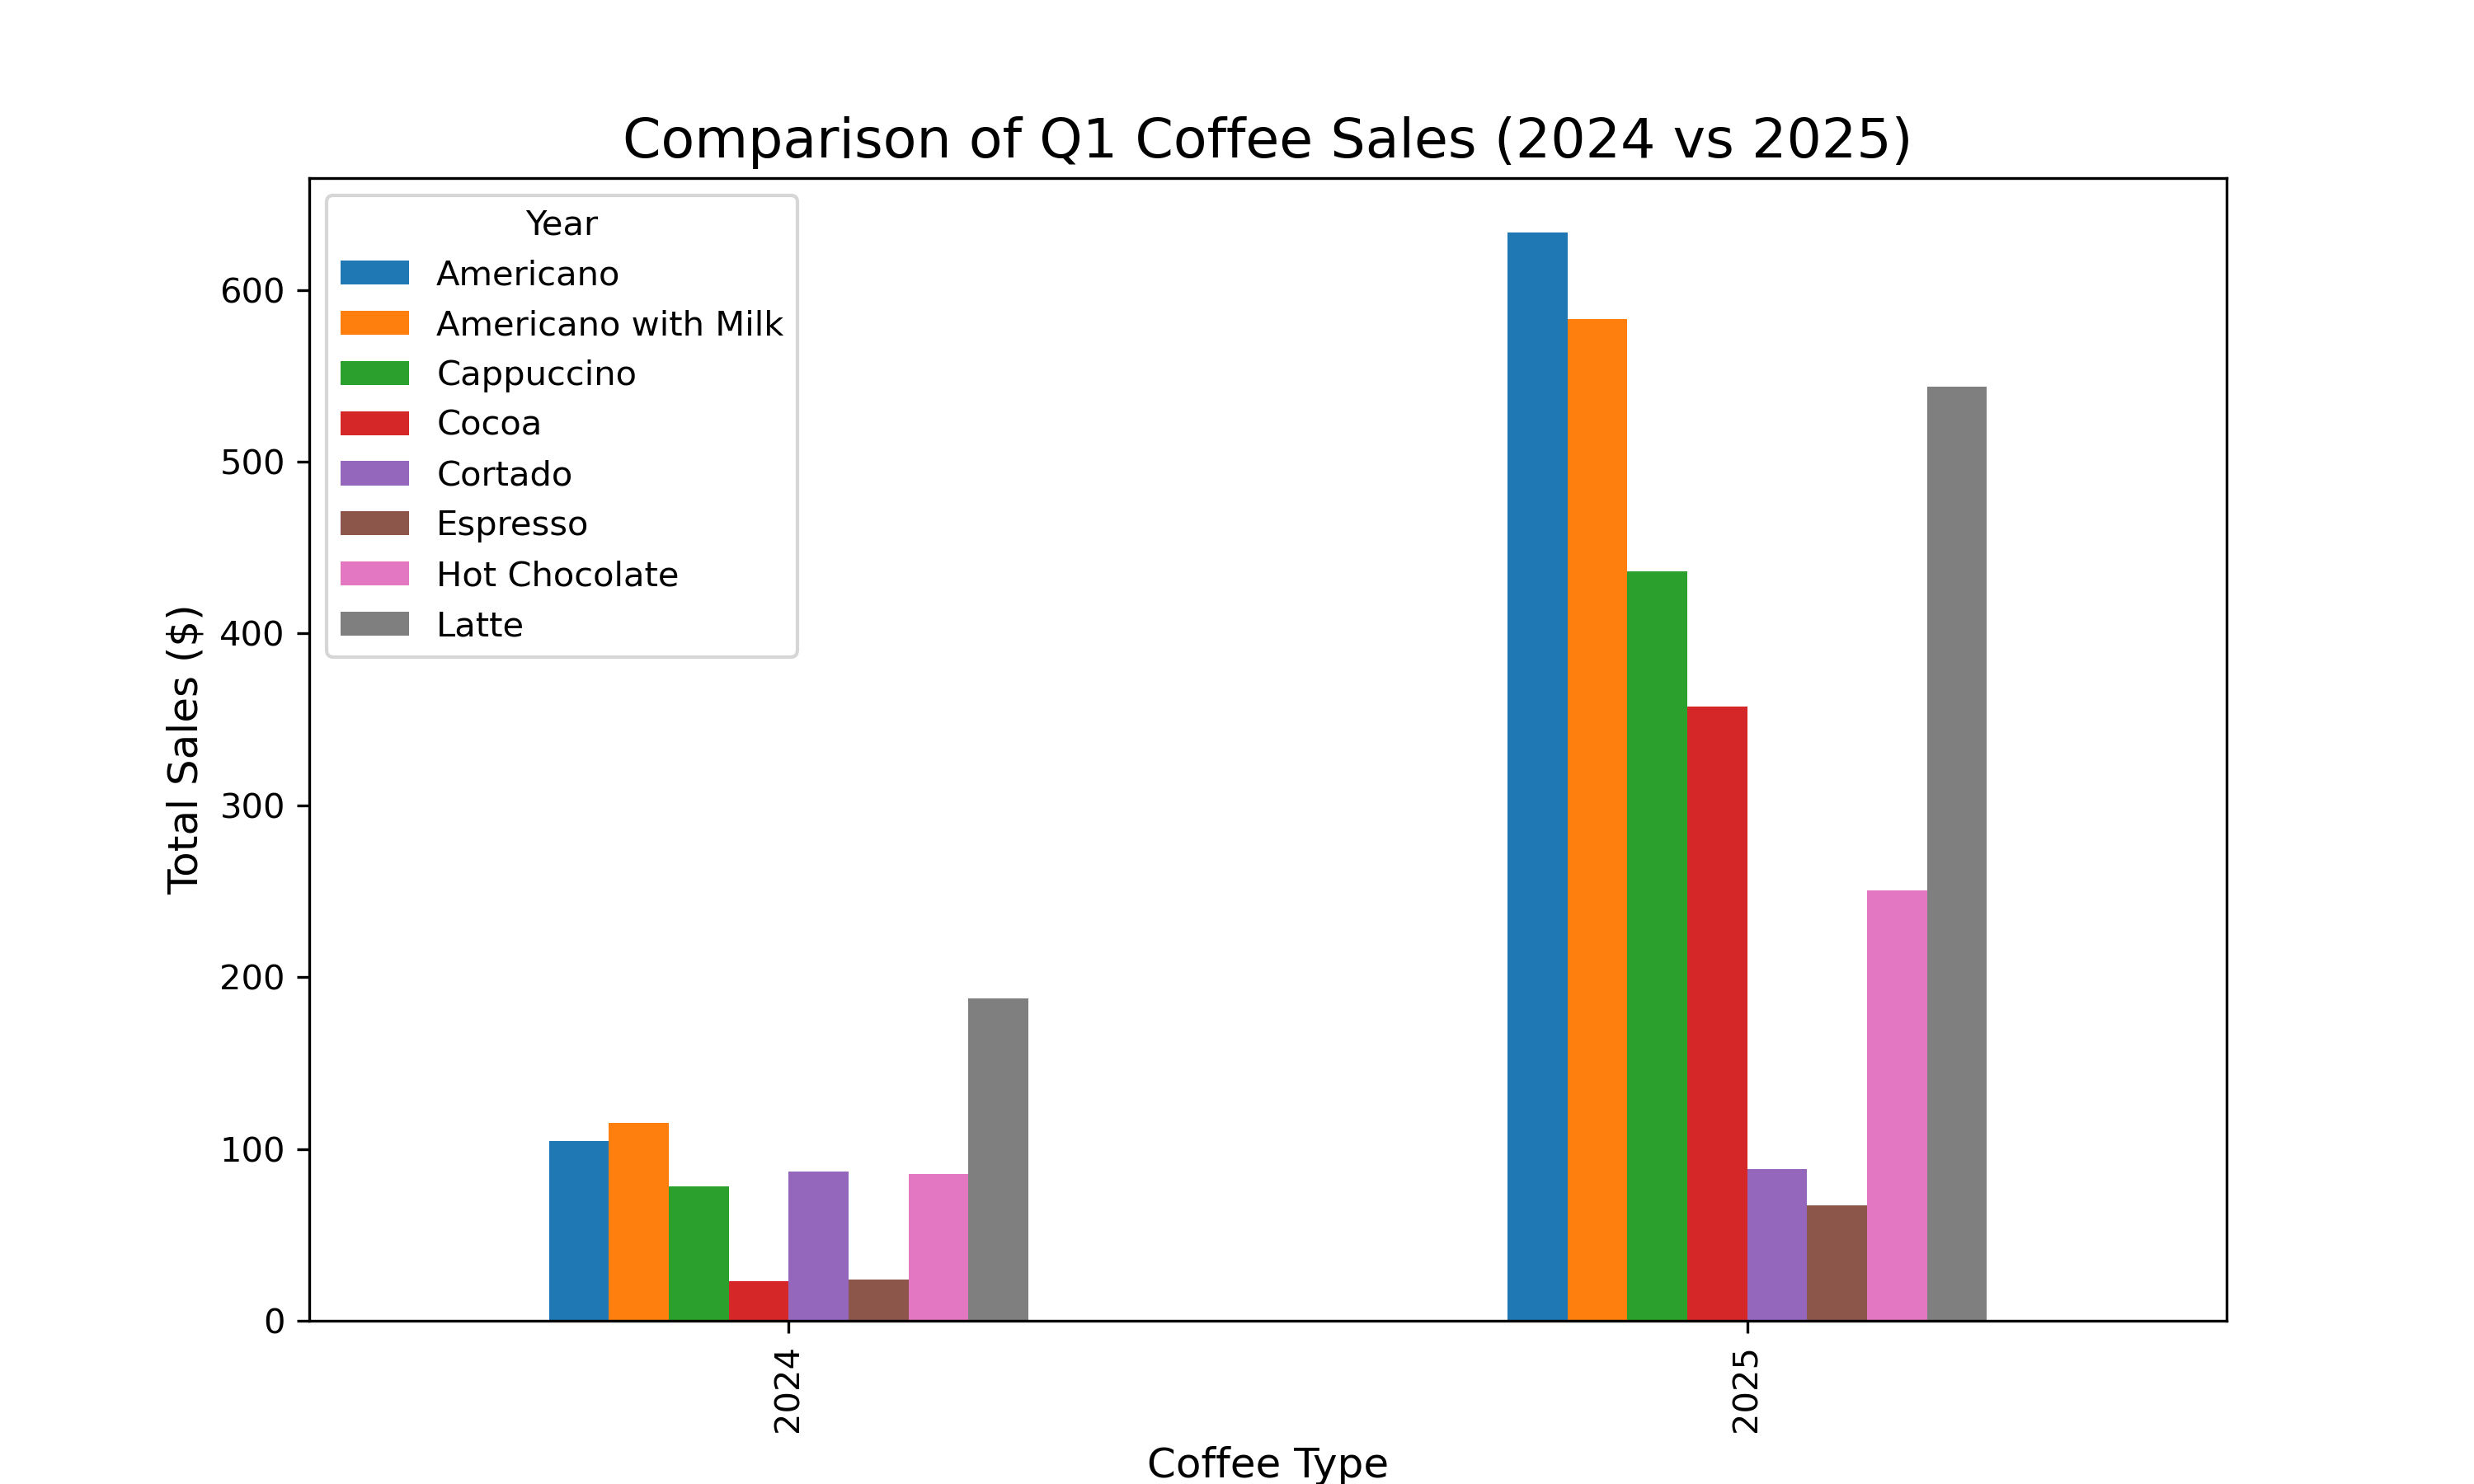

In [8]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
if match:
    initial_code = match.group(1).strip()
    utils.print_html(initial_code, title="Extracted Code to Execute")
    exec_globals = {"df": df}
    exec(initial_code, exec_globals)

# If code run successfully, the file chart_v1.png should have been generated
utils.print_html(
    content="chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

### 3.3. Step 3 — Reflect on the output

The goal here is to simulate how a human would review a first draft of a chart—looking for strengths, weaknesses, and areas for improvement.

Here’s what happens:

**1. Provide the chart to the LLM:**
The generated chart (chart_v1.png) is shared with the LLM so it can “see” the visualization.

**2. Analyze the chart visually:**
The LLM reviews elements like clarity, labeling, accuracy, and overall readability.

**3. Generate feedback:**
The LLM suggests improvements—for example, fixing axis labels, adjusting the chart type, improving color choices, or highlighting missing legends.

By doing this, you create an intelligent feedback loop where the chart is not just produced once, but actively critiqued—setting the stage for a stronger second version (V2).

In [ ]:
def reflect_on_image_and_regenerate(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
    code_v1: str,  
) -> tuple[str, str]:
    """
    Critique the chart IMAGE and the original code against the instruction, 
    then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    Supports OpenAI and Anthropic (Claude).

    Memo
    ----
    Why Base64 Encoding?
    - Multi-modal APIs require images in one of these formats:
        1. **URL** - Public image URL (not suitable for local files)
        2. **Base64** - Encoded image data embedded in the request ✅

    - Base64 encoding converts the binary image file into a text string that can be sent in the API request.
    """
    media_type, b64 = utils.encode_image_b64(chart_path)
    # media_type: "image/png"
    # b64: "iVBORw0KGgoAAAANSUhEUgAAA..." (base64 string)    

    prompt = f"""
    You are a data visualization expert.
    Your task: critique the attached chart and the original code against the given instruction,
    then return improved matplotlib code.

    Original code (for context):
    {code_v1}

    OUTPUT FORMAT (STRICT!):
    1) First line: a valid JSON object with ONLY the "feedback" field.
    Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

    2) After a newline, output ONLY the refined Python code wrapped in:
    <execute_python>
    ...
    </execute_python>

    3) Import all necessary libraries in the code. Don't assume any imports from the original code.

    HARD CONSTRAINTS:
    - Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
    - Use pandas/matplotlib only (no seaborn).
    - Assume df already exists; do not read from files.
    - Save to '{out_path_v2}' with dpi=300.
    - Always call plt.close() at the end (no plt.show()).
    - Include all necessary import statements.

    Schema (columns available in df):
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    Instruction:
    {instruction}
    """
    # In case the name is "Claude" or "Anthropic", use the safe helper
    lower = model_name.lower()
    if "claude" in lower or "anthropic" in lower:
        # ✅ Use the safe helper that joins all text blocks and adds a system prompt
        content = utils.image_anthropic_call(model_name, prompt, media_type, b64)
    else:
        content = utils.image_openai_call(model_name, prompt, media_type, b64)

    # --- Parse ONLY the first JSON line (feedback) ---
    lines = content.strip().splitlines()
    json_line = lines[0].strip() if lines else ""

    try:
        obj = json.loads(json_line)
    except Exception as e:
        # Fallback: try to capture the first {...} in all the content
        m_json = re.search(r"\{.*?\}", content, flags=re.DOTALL)
        if m_json:
            try:
                obj = json.loads(m_json.group(0))
            except Exception as e2:
                obj = {"feedback": f"Failed to parse JSON: {e2}", "refined_code": ""}
        else:
            obj = {"feedback": f"Failed to find JSON: {e}", "refined_code": ""}

    # --- Extract refined code from <execute_python>...</execute_python> ---
    m_code = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content)
    refined_code_body = m_code.group(1).strip() if m_code else ""
    refined_code = utils.ensure_execute_python_tags(refined_code_body)

    feedback = str(obj.get("feedback", "")).strip()
    return feedback, refined_code



Note that, the model is instructed to return its response in **JSON format**.  

- JSON is a lightweight, structured format (key–value pairs) that makes it easy to parse the LLM’s output programmatically.  
- Here, we require two fields:  
  - **`feedback`**: a short critique of the current chart.  
  - **`refined_code`**: an improved Python code snippet wrapped in `<execute_python>` tags.  

We also include a **“constraints” section** in the prompt. These rules (e.g., use matplotlib only, save the file to a specific path, call `plt.close()` at the end) help the model generate consistent, runnable code that fits the workflow. Without these constraints, the output might vary too much or include unwanted formatting.  


# Generate feedback alongside reflected code
feedback, code_v2 = reflect_on_image_and_regenerate(
    chart_path="chart_v1.png",            
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.", 
    model_name="o4-mini",  # Latest reasoning model (Oct 2025)
    # model_name="gpt-4o",  # Previous model
    out_path_v2="chart_v2.png",
    code_v1=code_v1,   # pass in the original code for context        
)

utils.print_html(feedback, title="Feedback on V1 Chart")
utils.print_html(code_v2, title="Regenerated Code Output (V2)")

In [ ]:
# Generate feedback alongside reflected code
feedback, code_v2 = reflect_on_image_and_regenerate(
    chart_path="chart_v1.png",            
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.", 
    model_name="o4-mini",
    out_path_v2="chart_v2.png",
    code_v1=code_v1,   # pass in the original code for context        
)

utils.print_html(feedback, title="Feedback on V1 Chart")
utils.print_html(code_v2, title="Regenerated Code Output (V2)")

Now you’ll execute the refined code returned by the reflection step.  The code inside the `<execute_python>` tags is extracted, run against the dataset, and used to generate the updated chart.  

If the execution is successful, you’ll see the new image (`chart_v2.png`) displayed below as the **Regenerated Chart (V2)**.  

In [ ]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
if match:
    reflected_code = match.group(1).strip()
    exec_globals = {"df": df}
    exec(reflected_code, exec_globals)

# If code run successfully, the file chart_v2.png should have been generated
utils.print_html(
    content="chart_v2.png",
    title="Regenerated Chart (V2)",
    is_image=True
)

### 4. Put it all together — creating the end-to-end workflow

Now it’s time to wrap everything into a single automated workflow the agent can run from start to finish.

The `run_workflow` function links together the components you implemented earlier:

1) **Load and prepare data** — via `utils.load_and_prepare_data(...)`.  
2) **Generate V1 code** — with `generate_chart_code(...)`, which returns the first-draft matplotlib code (wrapped in `<execute_python>` tags).  
3) **Execute V1 immediately** — the workflow extracts the code between `<execute_python>` tags and runs it to produce the first chart image.  
4) **Reflect and refine** — `reflect_on_image_and_regenerate(...)` critiques the V1 image (and the original code) against the instruction, returns concise **feedback** plus **revised code (V2)**.  
5) **Execute V2 immediately** — the refined code is extracted and executed to generate the improved chart.

### What this workflow accepts
- **`dataset_path`**: location of the input CSV.  
- **`user_instructions`**: the chart request (e.g., “Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.”).  
- **`generation_model`**: model used for the initial code generation.  
- **`reflection_model`**: model used for the image-based reflection and code refinement.  
- **`image_basename`**: base filename for saving chart images (e.g., `chart_v1.png`, `chart_v2.png`).  

> Note: The chart execution steps are intentionally **hard-coded** to run right after code generation/refinement. This mirrors the workflow in the lecture and ensures you see each draft’s output before moving on.


In [ ]:
def run_workflow(
    dataset_path: str,
    user_instructions: str,
    generation_model: str,
    reflection_model: str,   
    image_basename: str = "chart",
):
    """
    End-to-end pipeline:
      1) load dataset
      2) generate V1 code
      3) execute V1 → produce chart_v1.png
      4) reflect on V1 (image + original code) → feedback + refined code
      5) execute V2 → produce chart_v2.png

    Returns a dict with all artifacts (codes, feedback, image paths).
    """
    # 0) Load dataset; utils handles parsing and feature derivations (e.g., year/quarter)
    df = utils.load_and_prepare_data(dataset_path)
    utils.print_html(df.sample(n=5), title="Random Sample of Dataset")

    # Paths to store charts
    out_v1 = f"{image_basename}_v1.png"
    out_v2 = f"{image_basename}_v2.png"

    # 1) Generate code (V1)
    utils.print_html("Step 1: Generating chart code (V1)… 📈")
    code_v1 = generate_chart_code(
        instruction=user_instructions,
        model=generation_model,
        out_path_v1=out_v1,
    )
    utils.print_html(code_v1, title="LLM output with first draft code (V1)")

    # 2) Execute V1 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 2: Executing chart code (V1)… 💻")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
    if match:
        initial_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(initial_code, exec_globals)
    utils.print_html(out_v1, is_image=True, title="Generated Chart (V1)")

    # 3) Reflect on V1 (image + original code) to get feedback and refined code (V2)
    utils.print_html("Step 3: Reflecting on V1 (image + code) and generating improvements… 🔁")
    feedback, code_v2 = reflect_on_image_and_regenerate(
        chart_path=out_v1,
        instruction=user_instructions,
        model_name=reflection_model,
        out_path_v2=out_v2,
        code_v1=code_v1,  # pass original code for context
    )
    utils.print_html(feedback, title="Reflection feedback on V1")
    utils.print_html(code_v2, title="LLM output with revised code (V2)")

    # 4) Execute V2 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 4: Executing refined chart code (V2)… 🖼️")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
    if match:
        reflected_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(reflected_code, exec_globals)
    utils.print_html(out_v2, is_image=True, title="Regenerated Chart (V2)")

    return {
        "code_v1": code_v1,
        "chart_v1": out_v1,
        "feedback": feedback,
        "code_v2": code_v2,
        "chart_v2": out_v2,
    }


In [ ]:
# Here, insert your updates
user_instructions="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv." # write your instruction here

# Latest GPT-5.0 series models (October 2025)
# generation_model="gpt-5-codex"      # Fast, efficient for code generation
# reflection_model="gpt-5-mini"           # Advanced reasoning for reflection

# Previous generation models (commented out for reference)
generation_model="gpt-4o-mini"     # GPT-4 series
reflection_model="gpt-4o"          # GPT-4 series

image_basename="drink_sales"

# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)

In [ ]:
# Here, insert your updates
user_instructions="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv." # write your instruction here
generation_model="gpt-4.1-mini"
reflection_model="o4-mini"
image_basename="drink_sales"

# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)

## 5. Final Takeaways

In this lab, **you** practiced using reflection to improve chart outputs.
You learned to:

* Generate an initial chart (V1).
* Critique and refine it into a better version (V2).
* Automate the full workflow with different models.

The key idea: reflection helps **you** create clearer, more accurate, and more effective visualizations.


<div style="border:1px solid #22c55e; border-left:6px solid #16a34a; background:#dcfce7; border-radius:6px; padding:14px 16px; color:#064e3b; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

🎉 <strong>Congratulations!</strong>  

You’ve completed the lab on building an **agentic chart generation workflow**.  
Along the way, **you** practiced generating charts, reflecting on their quality, and refining them into clearer and more effective visualizations.  

With these skills, **you** are ready to design agentic pipelines that create data visualizations automatically while keeping them accurate, explainable, and polished. 🌟  

</div>

